In [1]:
import pandas as pd
pd.set_option("display.max_columns", 100)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

CSV_DATA = Path().cwd().parent.parent / "data/1_transformed"

In [2]:
df = pd.read_csv(CSV_DATA/'summary/ride_summary.csv')
df['start_date'] = pd.to_datetime(df['start_date'])
df['start_time'] = pd.to_timedelta(df['start_time'])
df['end_time'] = pd.to_timedelta(df['end_time'])

In [3]:
df.columns

Index(['ride_id', 'start_date', 'start_time', 'end_time', 'biker_weight_lbs',
       'bike_weight', 'bag_weight', 'avg_speed', 'avg_cruising_speed',
       'total_ride_time_sec', 'total_moving_time_sec', 'total_distance_mi',
       'total_ascent_ft', 'total_descent_ft', 'avg_heart_rate', 'avg_power',
       'avg_cadence', 'avg_ambient_temp_F', 'best_power_4s', 'best_power_5s',
       'best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
       'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
       'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
       'best_power_40m', 'best_power_1h', 'best_power_2h', 'best_power_3h',
       'best_power_4h'],
      dtype='object')

In [8]:
import re
def plot_summary_power_curves(df_summary:pd.DataFrame, ride_id_subset:list[str]=None, figsize:tuple=(12,4), 
                              logscale_base:int=10, title:str='Best Ride Efforts Power Curve'):
    # Subset the df_summary columns and filter for the relevant ride_ids
    cols_of_interest = ['ride_id', 'start_date','total_distance_mi','total_ascent_ft','avg_power']
    power_cols = ['best_power_4s', 'best_power_5s','best_power_10s', 'best_power_20s', 'best_power_30s', 'best_power_1m',
                    'best_power_2m', 'best_power_3m', 'best_power_4m', 'best_power_5m',
                    'best_power_6m', 'best_power_10m', 'best_power_20m', 'best_power_30m',
                    'best_power_40m', 'best_power_1h', 'best_power_2h', 'best_power_3h',
                    'best_power_4h']
    cols_of_interest += power_cols
    if ride_id_subset is None: ride_id_subset = df['ride_id'].values # if not specified, all rides will be plotted
    df_rides = df_summary.copy().loc[df_summary['ride_id'].isin(ride_id_subset), cols_of_interest]
    n_rides = df_rides.shape[0]

    # Create a mapping from power column names back to axis labels and values
    pattern = r'best_power_([\d]+)([smh])'
    seconds_map = {'s':1, 'm':60, 'h':60*60}
    power_col_map = dict()
    for col in power_cols:
        matched = re.match(pattern, col)
        if matched is not None:
            value, unit = matched.groups()
            power_col_map[col] = {'label':value+unit,'duration':int(value)*seconds_map[unit]}

    ########################################################################
    # Create the Figure
    fig, ax = plt.subplots(1,1, figsize=figsize)
    # For each ride, plot its power curve

    for _, row in df_rides.iterrows():
        ride_id = row['ride_id']
        data = [{'duration':power_col_map[col]['duration'], 'best_power':row[col]} for col in power_cols]
        df_pwr = pd.DataFrame(data)
        _ = sns.lineplot(df_pwr, x='duration', y='best_power', ax=ax, label=ride_id, alpha=0.99**n_rides, legend=False)
        _ = sns.scatterplot(df_pwr, x='duration', y='best_power', ax=ax, alpha=0.99**n_rides, legend=False)
    

    ########################################################################
    # Set the axes up for plotting
    def forward(x):
        return np.log10(x) / np.log10(logscale_base)

    def inverse(x):
        return logscale_base**x
    
    if logscale_base==10:
        _ = ax.set_xscale('log')
    else:
        _ = ax.set_xscale('function', functions=(forward,inverse))
    _ = plt.xticks(ticks=[col['duration'] for col in power_col_map.values()], 
                   labels=[col['label'] for col in power_col_map.values()], rotation=45)
    _ = plt.grid()
    _ = ax.set_axisbelow(True)
    _ = plt.xlabel('Effort Time Duration', fontsize=14)
    _ = plt.ylabel('Maximum Effort Power (W)', fontsize=14)
    _ = plt.title(title, fontsize=18)

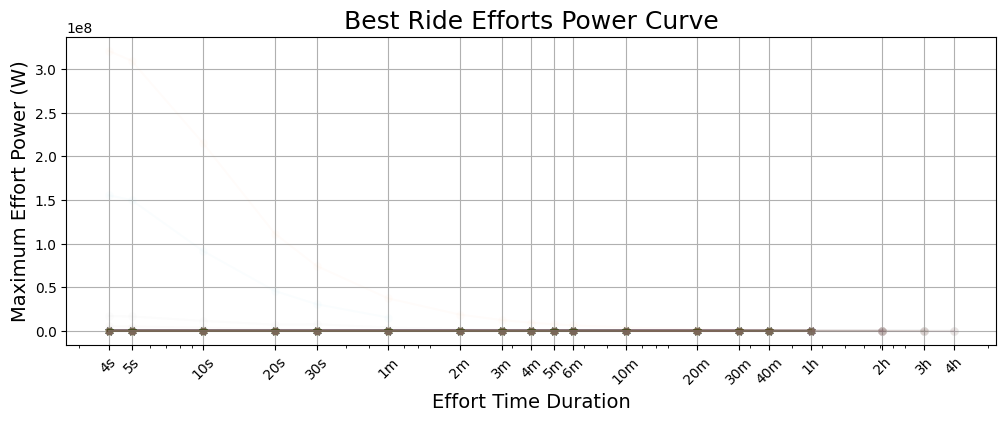

In [9]:
plot_summary_power_curves(df_summary=df)